## Principal Component Analysis
Principal component analysis (PCA) is a linear dimension reduction method which extracts features (principal components) to cover the variance of the original data as much as possible.  

In [768]:
import numpy as np
from sklearn.datasets import make_classification

In [769]:
X, y = make_classification(n_features=50, n_samples=500, n_redundant=5)
X += np.random.uniform(low=-5, high=10, size=(500, 50))

X.mean(), X.var(), X.shape

(np.float64(2.5154053426871017), np.float64(19.81389827678164), (500, 50))

### Standardize the dataset

In [770]:
X_standardized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

assert np.isclose(X_standardized.mean(), 0)
assert np.isclose(X_standardized.var(), 1.0)

### Compute the covariance matrix

In [771]:
cov_matrix = np.cov(X_standardized.T, ddof=0)

# Calculation of covariance matrix by matrix multiplication
cov_matrix_mult = (X_standardized.T @ X_standardized) / (X_standardized.shape[0])
assert np.isclose(cov_matrix, cov_matrix_mult).all()

# Alternative calculation of covariance matrix by Einstein summation
# s - num of samples
# v and k - num of variables
cov_matrix_einsum = np.einsum("sv,sk->vk", X_standardized, X_standardized) / (X_standardized.shape[0])
assert np.isclose(cov_matrix, cov_matrix_einsum).all()

# The diagonal contains the variances of the variables
assert np.isclose(cov_matrix.diagonal(), X_standardized.var(axis=0, ddof=0)).all()

### Compute eigenvalues and eigenvectors


In [772]:
eigvalues, eigvectors = np.linalg.eig(cov_matrix)


variance_argsorted = np.argsort(eigvalues)[::-1]
eigvalues = eigvalues[variance_argsorted]
eigvectors = eigvectors.T[variance_argsorted].T


## lambda_1 * u_1 == Sigma @ u_1 
assert np.allclose(eigvalues[0] * eigvectors.T[0], cov_matrix @ eigvectors.T[0])

## U @ Lambda == Sigma @ U
assert np.allclose((eigvectors @ np.diag(eigvalues)), cov_matrix @ eigvectors)

In [786]:
# Computing eigenvalues by U.T @ A @ U
eigvalues_alternative = np.diagonal(eigvectors.T @ cov_matrix @ eigvectors)
assert np.allclose(eigvalues, eigvalues_alternative)

# Reconstruct the input data from principal components
reconstruction = (X @ eigvectors) @ eigvectors.T
assert np.allclose(reconstruction, X)

In [454]:
principal_components = (X_standardized @ eigvectors)

# Eigenvalues contain the variances of principal components
assert np.allclose(np.var(principal_components, axis=0, ddof=0), eigvalues)

In [455]:
explained_var_percent = (eigvalues.cumsum() / eigvalues.sum()) * 100
"Number of components needed to explain 80% of the variance:", int(np.argmax(explained_var_percent > 80) + 1)

('Number of components needed to explain 80% of the variance:', 35)

In [456]:
(X_standardized @ eigvectors[:, :3])

array([[-2.68624856,  0.36429041, -0.91613503],
       [ 0.08489141,  2.75300301,  0.97087311],
       [-1.39884917, -0.25929258,  0.4877163 ],
       ...,
       [-0.57232192,  1.42063675, -1.74362574],
       [-0.29440267, -0.01906171, -0.2219166 ],
       [ 0.43093147, -0.00660545,  0.43389058]])

### Compare the results with Pytorch implementation

In [457]:
from torch import pca_lowrank
import torch

In [458]:
U, S, V = pca_lowrank(torch.tensor(X_standardized), center=False, niter=2, q=50)
U = U.numpy()
S = S.numpy()
V = V.numpy()

torch_eigvals = S ** 2 / 500
assert np.allclose(torch_eigvals[0] * V.T[0], cov_matrix @ V.T[0])

# Eigenvalues are the same
assert np.allclose(torch_eigvals, eigvalues)

# Eigenvectors are the same (except for the sign)
assert np.allclose(np.abs(eigvectors), np.abs(V))

In [459]:
U, S, V = pca_lowrank(torch.tensor(X) - torch.tensor(X.mean(axis=0)), center=False, niter=2, q=50)
U = U.numpy()
S = S.numpy()
V = V.numpy()

torch_eigvals = S ** 2 / 500
torch_eigvals

array([32.45454874, 31.62062785, 30.61540565, 30.30046418, 29.79838033,
       28.37559353, 28.2383852 , 27.69856585, 26.8903556 , 26.40658215,
       25.58402589, 24.97395428, 24.52186883, 23.76509058, 23.70342017,
       23.20295388, 22.90383614, 22.04280186, 21.28387017, 21.15207653,
       20.88470154, 20.41540844, 20.21145989, 19.77657078, 19.36051952,
       18.91519023, 18.47492462, 17.7656616 , 17.62982702, 17.44515878,
       16.8978906 , 16.58095317, 16.43139258, 15.81532748, 15.68272038,
       15.6402164 , 15.12240066, 14.76966007, 14.50084699, 13.94838871,
       13.70747598, 13.35260347, 13.12585336, 12.29327605, 12.01951288,
       11.9001706 , 10.75064828, 10.70056131, 10.42768144,  9.94362544])

In [460]:
X_standardized = X - X.mean(axis=0)
cov_matrix = np.cov(X_standardized.T, ddof=0)

eigvalues, eigvectors = np.linalg.eig(cov_matrix)
principal_components = (X_standardized @ eigvectors)

(np.abs(np.sort(eigvalues)[::-1] - torch_eigvals)).sum()

np.float64(1.6395773627664312e-12)

### PCA on MNIST dataset

In [724]:
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch


import matplotlib.pyplot as plt

In [630]:
transformer = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(0.5, 0.5)
])

dataset = MNIST(root="data", train=True, download=True, transform=transformer)

dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [642]:
train_loader = DataLoader(dataset, batch_size=len(dataset))
data_X, data_y = next(iter(train_loader))


num_of_vars = torch.prod(torch.tensor(data_X.shape[1:]))

flat_X = data_X.view((-1, num_of_vars))

In [739]:
# Implementation of PCA with pytorch
def PCA(data_X: torch.Tensor, center=True, unit_variance=False):
    X = torch.clone(data_X)
    if center:
        X = X - X.mean(axis=0, keepdim=True)
    if unit_variance:
        std_eps = 1e-8  # Avoid dividing by 0 
        X =  X / (X.std(axis=0, unbiased=True, keepdim=True) + std_eps)

    cov_matrix = X.T.cov(correction=0)

    eigvalues, eigvectors = torch.linalg.eigh(cov_matrix)

    eigvalues, sort_args = torch.sort(eigvalues, descending=True)
    eigvectors = eigvectors.T[sort_args].T
    return eigvalues, eigvectors

In [740]:
S_own, V_own = PCA(flat_X, center=True, unit_variance=False)

More than 75% variance:

In [753]:
var_treshold = 0.75
explained_var_percent = (S_own.cumsum(dim=0) / S_own.abs().sum())
"Number of components needed to explain 75% of the variance:", int(np.argmax(explained_var_percent > var_treshold) + 1)

('Number of components needed to explain 80% of the variance:', 34)

Visualization of the first two principal components

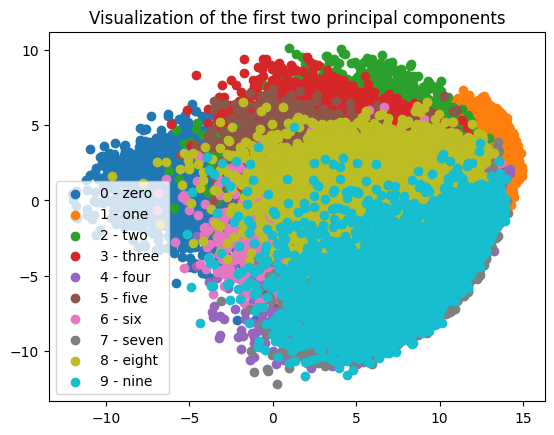

In [876]:
first_two_pcs = (flat_X @ V_own[:, :2])
for class_name, label_idx in dataset.class_to_idx.items():
    label_mask = data_y == label_idx
    
    plt.scatter(first_two_pcs[label_mask, 0], first_two_pcs[label_mask, 1], label=class_name)
plt.legend()
plt.title("Visualization of the first two principal components");

Image reconstruction

Random chosen images:


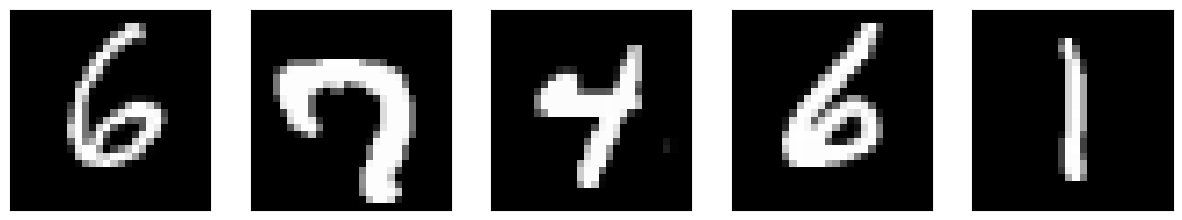

Images reconstructed from 80 principal components:


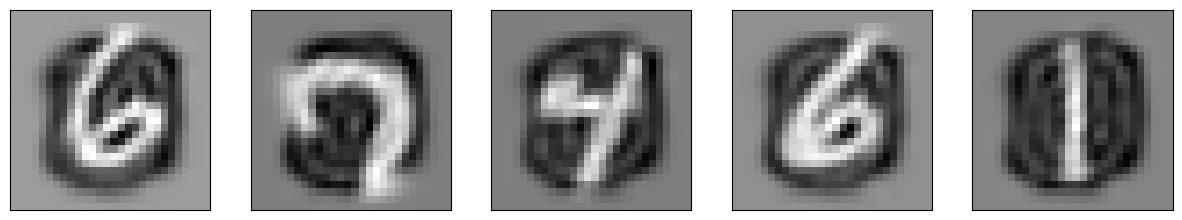

In [846]:
np.random.seed(None)
n_samples = 5
n_used_components = 80

random_idx = np.random.randint(data_X.shape[0], size=n_samples)
chosen_images = data_X[random_idx].squeeze()

print(f"Random chosen images:")

plt.figure(figsize=(15, 10))
for i, image in enumerate(chosen_images):
    plt.subplot(1, n_samples, i + 1)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(image, cmap="grey")

reconstructions = []

for image in chosen_images:
    flattened = image.flatten()
    reconstruction = (flattened @ V_own[:, :n_used_components]) @ V_own[:, :n_used_components].T
    reconstructions.append(reconstruction.reshape(-1, int(reconstruction.shape[0] ** (1/2))))
plt.show()
plt.figure(figsize=(15, 10))
for i, image in enumerate(reconstructions):
    plt.subplot(1, n_samples, i + 1)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(image, cmap="grey")

print(f"Images reconstructed from {n_used_components} principal components:")
